<a href="https://colab.research.google.com/github/OozyGrub/nasdaq100-trading-algorithm/blob/main/nasdaq100_trading_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!pip install yfinance -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install --upgrade -q ta

     |████████████████████████████████| 6.3MB 7.4MB/s 


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Preparation

In [3]:
# configuration
period = '2y'

In [4]:
# msft = yf.Ticker("MSFT")
# aapl = yf.Ticker("AAPL")
# get historical market data
# hist = msft.history(period = period)
# hist.plot()
# for hist in tickers:
#     hist.plot()

# stocks = ["MSFT", "AAPL", "AAME", "AACG", "ACIW", "ACRX"]

stocks = ["AAPL","ADBE","ADI","ADP","ADSK",
"AEP","ALGN",
"ALXN",
"AMAT",
"AMD",
"AMGN",
"AMZN",
"ANSS",
"ASML",
"ATVI",
"AVGO",
"BIDU",
"BIIB",
"BKNG",
"CDNS",
"CDW",
"CERN",
"CHKP",
"CHTR",
"CMCSA",
"COST",
"CPRT",
"CSCO",
"CSX",
"CTAS",
"CTSH",
"DLTR",
"DOCU",
"DXCM",
"EA",
"EBAY",
"EXC",
"FAST",
"FB",
"FISV",
"FOX",
"FOXA",
"GILD",
"GOOG",
"GOOGL",
"IDXX",
"ILMN",
"INCY",
"INTC",
"INTU",
"ISRG",
"JD",
"KDP",
"KHC",
"KLAC",
"LRCX",
"LULU",
"MAR",
"MCHP",
"MDLZ",
"MELI",
"MNST",
"MRNA",
"MRVL",
"MSFT",
"MTCH",
"MU",
"MXIM",
"NFLX",
"NTES",
"NVDA",
"NXPI",
"OKTA",
"ORLY",
"PAYX",
"PCAR",
"PDD",
"PEP",
"PTON",
"PYPL",
"QCOM",
"REGN",
"ROST",
"SBUX",
"SGEN",
"SIRI",
"SNPS",
"SPLK",
"SWKS",
"TCOM",
"TEAM",
"TMUS",
"TSLA",
"TXN",
"VRSK",
"VRSN",
"VRTX",
"WBA",
"WDAY",
"XEL",
"XLNX",
"ZM"]
num_stocks = len(stocks)
stock_dict = dict(enumerate(stocks))
idx_to_stock = dict([(val, key) for key, val in stock_dict.items()])

tickers = [yf.Ticker(stock).history(period=period) for stock in stocks]

In [5]:
# for key, val in msft.info.items():
#     print(f"{key}: {val}")

In [6]:
# hist['Close'].plot(figsize=(16, 9))

In [7]:
from ta import add_all_ta_features
from ta.utils import dropna

def with_features(x):
    return add_all_ta_features(x, open="Open", high="High", low="Low", close="Close", volume="Volume")

df = []
for ticker in tickers:
    try:
        x = with_features(ticker)
        df.append(x)
    except:
        print(ticker)

In [8]:
df[0][['momentum_tsi', 'Close']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 2019-05-07 to 2021-05-07
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   momentum_tsi  469 non-null    float64
 1   Close         506 non-null    float64
dtypes: float64(2)
memory usage: 11.9 KB


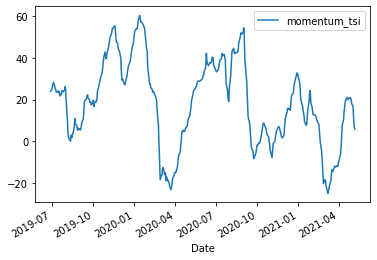

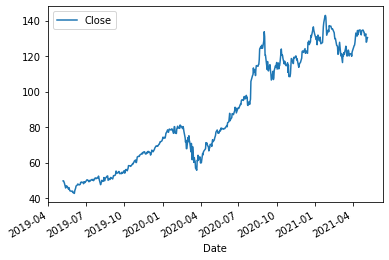

In [9]:
df[0][['momentum_tsi']].plot()
df[0][['Close']].plot()

## Multiple Strategy

In [17]:
from datetime import timedelta, date
from dateutil import relativedelta

# configs
decimal_display = 2
start_date = date(2019, 10, 1)
end_date = date(2021, 5, 1)
debug = False
initial_balance = 100.00



def calculate_position_balance(at_date):
    prices = [df[j]['Close'].get(to_date_key(at_date)) if 
              df[j]['Close'].get(to_date_key(at_date)) else 
              find_nearest_price(j, at_date) 
              for j in range(num_stocks)]
    return np.dot(position, prices)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def to_date_key(x):
    return x.strftime("%Y-%m-%d")

def buy(amount, price):
    return amount / price

def sell(amount, price):
    return amount * price

def find_nearest_price(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['Close'].get(to_date_key(date)):
            return df[i]['Close'].get(to_date_key(date))

def find_nearest_tsi(i, date):
    while True:
        date -= timedelta(1)
        if df[i]['momentum_tsi'].get(to_date_key(date)):
            return df[i]['momentum_tsi'].get(to_date_key(date))

def get_tsi_data(date):
    return [(key, x['momentum_tsi'].get(to_date_key(date)) if
             x['momentum_tsi'].get(to_date_key(date)) else
             find_nearest_tsi(key, date)) for
            key, x in enumerate(df)]

In [18]:
from itertools import permutations, product

month_period_params = [1]
num_stock_hold_params = [5]
sell_threshold_params = [[1.25, 1.50, 1.75]]
sell_ratio_params = [[.2, .2, .2], [.2, .3, .4], [.1, .2, .3]]
# cut_loss
cut_loss_threshold_params = [.8]
# cut_loss_sell

product_params = list(product(month_period_params,
                   num_stock_hold_params,
                   sell_threshold_params,
                   sell_ratio_params,
                   cut_loss_threshold_params))
product_params_size = len((product_params))

In [19]:
from tqdm.auto import tqdm, trange

0 -> total balance: 194.66


1 -> total balance: 195.08


2 -> total balance: 194.88



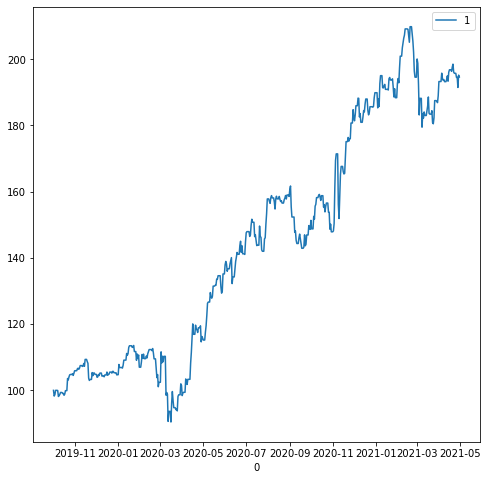

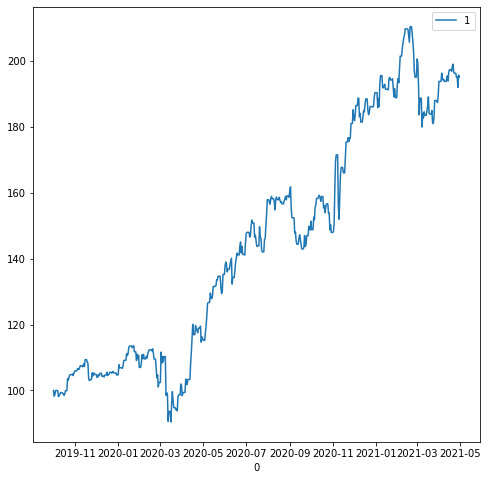

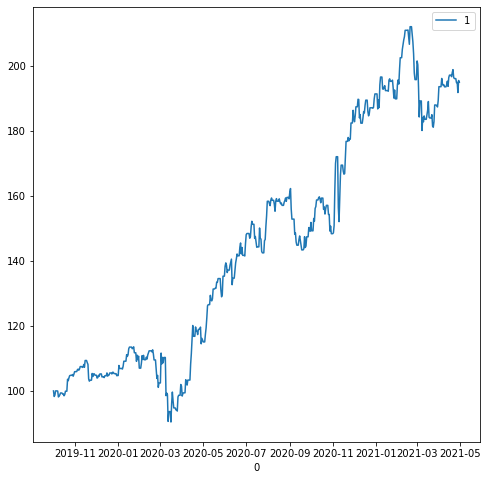

In [20]:
results = [] # (idx, balance)[]

for idx in trange(product_params_size, desc='product_params'):
    # params
    month_period = product_params[idx][0]
    num_stock_hold = product_params[idx][1]
    sell_threshold = product_params[idx][2]
    sell_ratio = product_params[idx][3]
    cut_loss_threshold = product_params[idx][4]

    # initial vars
    total_balance = initial_balance
    position = [0.00] * num_stocks
    state = [0] * num_stocks
    buy_at = [0.00] * num_stocks
    selected_stock = []
    acc_total_balances = []
    month_count = 0

    trading_token = 0

    def hit_sell_threshold(i, price, buy_price):
        return price >= buy_price * sell_threshold[i]

    def hit_cut_loss_threshold(price, buy_price):
        return price <= buy_price * cut_loss_threshold
        
    for single_date in tqdm(list(daterange(start_date, end_date)),leave=False, desc='date'):
        date_key = to_date_key(single_date)

        # Trading period
        if single_date.day == 1:
            if month_count % month_period == 0:
                trading_token = 1
            month_count += 1

        if trading_token == 1:
            trading_token = 0
            # select stock by top tsi
            tsi_data = get_tsi_data(single_date)
            tsi_data.sort(key=lambda x:-x[1])
            top_stock = tsi_data[5: num_stock_hold + 5]
            selected_stock = list(map(lambda x : x[0], top_stock))
            if debug:
                printmd(f"Month {month_count}")
                # print([stock_dict[i] for i in selected_stock])
                print(list(map(lambda x : (stock_dict[x[0]], x[1]), top_stock)))

            # sell all if not top
            for i in range(num_stocks):
                price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                if position[i] > 0.0 and (i not in selected_stock):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    state[i] = 0
                    buy_at[i] = 0
                    position[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🧧 sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

            # buy all top
            partial_balance = total_balance / num_stock_hold
            if partial_balance > 0.0:
                for i in selected_stock:
                    price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                    amount = buy(partial_balance, price)
                    total_balance -= partial_balance
                    position[i] += amount
                    buy_at[i] = price
                    state[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🟢 buy {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

        # Watch stock price
        for i in selected_stock:
            price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
            if position[i] > 0.0:
                # sell
                if state[i] < len(sell_threshold) and hit_sell_threshold(state[i], price, buy_at[i]):
                    amount = position[i] * sell_ratio[state[i]]
                    total_balance += sell(amount, price)
                    position[i] -= amount
                    state[i] += 1
                    symbol = "🔴" * state[i]
                    if debug:
                        # print(position)
                        print(f"{date_key} {symbol} sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

                # cut loss
                if hit_cut_loss_threshold(price, buy_at[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 cut_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
        acc_total_balances.append((single_date, total_balance + calculate_position_balance(single_date)))
        # print(calculate_position_balance(single_date))

    pd.set_option('display.max_rows', 100)
    acc_total_balance_df = pd.DataFrame(acc_total_balances)
    acc_total_balance_df = acc_total_balance_df.set_index(0)
    acc_total_balance_df.plot(figsize=(8, 8))

    total_balance += calculate_position_balance(end_date)

    # Saving results
    results.append((idx, total_balance))

    if debug: print("-------- 📈 Summary --------")
    print(f"{idx} -> total balance: {round(total_balance, decimal_display)}")

count      3.000000
mean     194.871622
std        0.206997
min      194.662023
25%      194.769476
50%      194.876930
75%      194.976422
max      195.075914
Name: 1, dtype: float64

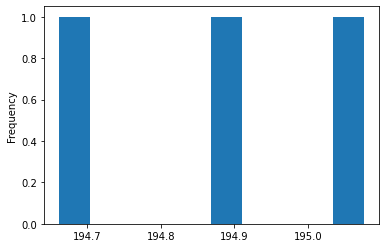

In [14]:
result_df = pd.DataFrame(results)
result_df[1].plot.hist(bins=10)
result_df[1].describe()

In [15]:
results.sort(key=lambda x:x[1], reverse=True)
for result in results[:5]:
    idx = result[0]
    params = product_params[idx]

    month_period = params[0]
    num_stock_hold = params[1]
    sell_threshold = params[2]
    sell_ratio = params[3]
    cut_loss_threshold = params[4]

    print(f"{idx}   total balance : {round(result[1], 100)}")
    print(f"        month_period: {month_period}")
    print(f"        num_stock_hold: {num_stock_hold}")
    print(f"        sell_threshold: {sell_threshold}")
    print(f"        sell_ratio: {sell_ratio}")
    print(f"        cut_loss_threshold: {cut_loss_threshold}")
    print()

1   total balance : 195.07591425747705
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.3, 0.4]
        cut_loss_threshold: 0.8

2   total balance : 194.87692960005782
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.1, 0.2, 0.3]
        cut_loss_threshold: 0.8

0   total balance : 194.662022954875
        month_period: 1
        num_stock_hold: 5
        sell_threshold: [1.25, 1.5, 1.75]
        sell_ratio: [0.2, 0.2, 0.2]
        cut_loss_threshold: 0.8



In [16]:
results = [] # (idx, balance, avg)[]

for idx in trange(product_params_size, desc='product_params'):
    # params
    month_period = product_params[idx][0]
    num_stock_hold = product_params[idx][1]
    sell_threshold = product_params[idx][2]
    sell_ratio = product_params[idx][3]
    cut_loss_threshold = product_params[idx][4]

    # initial vars
    total_balance = initial_balance
    position = [0.00] * num_stocks
    state = [0] * num_stocks
    buy_at = [0.00] * num_stocks
    selected_stock = []
    acc_total_balances = []
    month_count = 0

    avg = 0

    trading_token = 0

    def hit_sell_threshold(i, price, buy_price):
        return price >= buy_price * sell_threshold[i]

    def hit_cut_loss_threshold(price, buy_price):
        return price <= buy_price * cut_loss_threshold
        
    for single_date in tqdm(list(daterange(start_date, end_date)),leave=False, desc='date'):
        date_key = to_date_key(single_date)

        # Trading period
        if single_date.day == 1:
            if month_count % month_period == 0:
                trading_token = 1
            month_count += 1

        if trading_token == 1:
            trading_token = 0
            # select stock by top tsi
            tsi_data = get_tsi_data(single_date)
            tsi_data.sort(key=lambda x:-x[1])
            top_stock = tsi_data[5: num_stock_hold + 5]
            selected_stock = list(map(lambda x : x[0], top_stock))
            if debug:
                printmd(f"Month {month_count}")
                # print([stock_dict[i] for i in selected_stock])
                print(list(map(lambda x : (stock_dict[x[0]], x[1]), top_stock)))

            # sell all if not top
            for i in range(num_stocks):
                price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                if position[i] > 0.0 and (i not in selected_stock):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    state[i] = 0
                    buy_at[i] = 0
                    position[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🧧 sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

            avg += total_balance - 100.00
            total_balance = 100.00

            # buy all top
            partial_balance = total_balance / num_stock_hold
            if partial_balance > 0.0:
                for i in selected_stock:
                    price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
                    amount = buy(partial_balance, price)
                    total_balance -= partial_balance
                    position[i] += amount
                    buy_at[i] = price
                    state[i] = 0
                    if debug:
                        # print(position)
                        print(f"{date_key} 🟢 buy {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

        # Watch stock price
        for i in selected_stock:
            price = df[i]['Close'].get(date_key) if df[i]['Close'].get(date_key) else find_nearest_price(i, single_date)
            if position[i] > 0.0:
                # sell
                if state[i] < len(sell_threshold) and hit_sell_threshold(state[i], price, buy_at[i]):
                    amount = position[i] * sell_ratio[state[i]]
                    total_balance += sell(amount, price)
                    position[i] -= amount
                    state[i] += 1
                    symbol = "🔴" * state[i]
                    if debug:
                        # print(position)
                        print(f"{date_key} {symbol} sell {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")

                # cut loss
                if hit_cut_loss_threshold(price, buy_at[i]):
                    amount = position[i]
                    total_balance += sell(amount, price)
                    buy_at[i] = 0.0
                    position[i] = 0.0
                    state[i] += 1
                    if debug:
                        # print(position)
                        print(f"{date_key} 🔥 cut_loss {stock_dict[i]} at: {round(price, decimal_display)}, amount: {round(amount, decimal_display)}, total_balance: {round(total_balance, decimal_display)}")
        acc_total_balances.append((single_date, total_balance + calculate_position_balance(single_date)))
        # print(calculate_position_balance(single_date))

    # pd.set_option('display.max_rows', 100)
    # acc_total_balance_df = pd.DataFrame(acc_total_balances)
    # acc_total_balance_df = acc_total_balance_df.set_index(0)
    # acc_total_balance_df.plot(figsize=(8, 8))

    total_balance += calculate_position_balance(end_date)
    avg /= month_count

    # Saving results
    results.append((idx, total_balance, avg))

    if debug: print("-------- 📈 Summary --------")
    print(f"{idx} -> total balance: {round(total_balance, decimal_display)}, avg: {avg}")

Month 1

[('AEP', 22.531289177877177), ('XEL', 21.942662255744423), ('SGEN', 21.24162514304528), ('EXC', 20.096884432253443), ('AAPL', 19.673524652676964)]
2019-10-01 🟢 buy AEP at: 88.76, amount: 0.23, total_balance: 80.0
2019-10-01 🟢 buy XEL at: 62.41, amount: 0.32, total_balance: 60.0
2019-10-01 🟢 buy SGEN at: 86.0, amount: 0.23, total_balance: 40.0
2019-10-01 🟢 buy EXC at: 45.4, amount: 0.44, total_balance: 20.0
2019-10-01 🟢 buy AAPL at: 55.42, amount: 0.36, total_balance: 0.0


Month 2

[('AAPL', 42.211921312870274), ('VRTX', 40.671432730664776), ('SWKS', 38.48428087956857), ('PDD', 37.88427220673615), ('LRCX', 37.77188830799423)]
2019-11-01 🧧 sell AEP at: 89.08, amount: 0.23, total_balance: 20.07
2019-11-01 🧧 sell EXC at: 42.9, amount: 0.44, total_balance: 38.97
2019-11-01 🧧 sell SGEN at: 106.45, amount: 0.23, total_balance: 63.73
2019-11-01 🧧 sell XEL at: 60.64, amount: 0.32, total_balance: 83.16
2019-11-01 🟢 buy AAPL at: 63.12, amount: 0.32, total_balance: 80.0
2019-11-01 🟢 buy VRTX at: 200.94, amount: 0.1, total_balance: 60.0
2019-11-01 🟢 buy SWKS at: 96.17, amount: 0.21, total_balance: 40.0
2019-11-01 🟢 buy PDD at: 41.49, amount: 0.48, total_balance: 20.0
2019-11-01 🟢 buy LRCX at: 271.91, amount: 0.07, total_balance: 0.0
2019-11-20 🔥 cut_loss PDD at: 31.4, amount: 0.48, total_balance: 15.14


Month 3

[('VRTX', 50.76354731271967), ('INCY', 49.10806766361794), ('ANSS', 47.83297991689221), ('REGN', 44.96806157791313), ('ADBE', 43.136079590235404)]
2019-12-01 🧧 sell AAPL at: 66.14, amount: 0.68, total_balance: 59.96
2019-12-01 🧧 sell LRCX at: 260.74, amount: 0.07, total_balance: 79.14
2019-12-01 🧧 sell SWKS at: 96.17, amount: 0.21, total_balance: 99.14
2019-12-01 🟢 buy VRTX at: 221.75, amount: 0.09, total_balance: 80.0
2019-12-01 🟢 buy INCY at: 94.16, amount: 0.21, total_balance: 60.0
2019-12-01 🟢 buy ANSS at: 254.69, amount: 0.08, total_balance: 40.0
2019-12-01 🟢 buy REGN at: 369.0, amount: 0.05, total_balance: 20.0
2019-12-01 🟢 buy ADBE at: 309.53, amount: 0.06, total_balance: 0.0


Month 4

[('AAPL', 49.21298616111402), ('MSFT', 45.95336991390319), ('MTCH', 44.10328286879355), ('NXPI', 43.75705675715406), ('AMD', 43.21574253571947)]
2020-01-01 🧧 sell ADBE at: 329.81, amount: 0.06, total_balance: 21.31
2020-01-01 🧧 sell ANSS at: 257.41, amount: 0.08, total_balance: 41.52
2020-01-01 🧧 sell INCY at: 87.32, amount: 0.21, total_balance: 60.07
2020-01-01 🧧 sell REGN at: 375.48, amount: 0.05, total_balance: 80.42
2020-01-01 🧧 sell VRTX at: 218.95, amount: 0.19, total_balance: 121.96
2020-01-01 🟢 buy AAPL at: 72.68, amount: 0.28, total_balance: 80.0
2020-01-01 🟢 buy MSFT at: 155.69, amount: 0.13, total_balance: 60.0
2020-01-01 🟢 buy MTCH at: 82.11, amount: 0.24, total_balance: 40.0
2020-01-01 🟢 buy NXPI at: 125.22, amount: 0.16, total_balance: 20.0
2020-01-01 🟢 buy AMD at: 45.86, amount: 0.44, total_balance: 0.0


Month 5

[('ADBE', 45.066632419335775), ('TEAM', 40.16129074670704), ('MNST', 39.23447999476957), ('ADSK', 38.8476576856538), ('VRSN', 36.334522080578374)]
2020-02-01 🧧 sell AAPL at: 76.6, amount: 0.28, total_balance: 21.08
2020-02-01 🧧 sell AMD at: 47.0, amount: 0.44, total_balance: 41.58
2020-02-01 🧧 sell MSFT at: 168.06, amount: 0.13, total_balance: 63.17
2020-02-01 🧧 sell MTCH at: 78.22, amount: 0.24, total_balance: 82.22
2020-02-01 🧧 sell NXPI at: 124.83, amount: 0.16, total_balance: 102.16
2020-02-01 🟢 buy ADBE at: 351.14, amount: 0.06, total_balance: 80.0
2020-02-01 🟢 buy TEAM at: 147.0, amount: 0.14, total_balance: 60.0
2020-02-01 🟢 buy MNST at: 66.6, amount: 0.3, total_balance: 40.0
2020-02-01 🟢 buy ADSK at: 196.85, amount: 0.1, total_balance: 20.0
2020-02-01 🟢 buy VRSN at: 208.14, amount: 0.1, total_balance: 0.0


Month 6

[('GILD', 20.890512606207714), ('TSLA', 19.77621645645905), ('NFLX', 19.318530392658054), ('MRNA', 16.80879997844641), ('BIIB', 16.28123179267657)]
2020-03-01 🧧 sell ADBE at: 345.12, amount: 0.06, total_balance: 19.66
2020-03-01 🧧 sell ADSK at: 190.88, amount: 0.1, total_balance: 39.05
2020-03-01 🧧 sell MNST at: 62.41, amount: 0.3, total_balance: 57.79
2020-03-01 🧧 sell TEAM at: 144.96, amount: 0.14, total_balance: 77.51
2020-03-01 🧧 sell VRSN at: 189.75, amount: 0.1, total_balance: 95.75
2020-03-01 🟢 buy GILD at: 65.9, amount: 0.3, total_balance: 80.0
2020-03-01 🟢 buy TSLA at: 133.6, amount: 0.15, total_balance: 60.0
2020-03-01 🟢 buy NFLX at: 369.03, amount: 0.05, total_balance: 40.0
2020-03-01 🟢 buy MRNA at: 25.93, amount: 0.77, total_balance: 20.0
2020-03-01 🟢 buy BIIB at: 308.39, amount: 0.06, total_balance: 0.0
2020-03-16 🔥 cut_loss TSLA at: 89.01, amount: 0.15, total_balance: 13.33


Month 7

[('NFLX', 1.9598642693901835), ('JD', 1.2294408072163447), ('SGEN', 0.9841246951539382), ('PDD', 0.8070164840190006), ('PTON', 0.05662230082780834)]
2020-04-01 🧧 sell BIIB at: 293.27, amount: 0.06, total_balance: 32.35
2020-04-01 🧧 sell GILD at: 69.54, amount: 0.3, total_balance: 53.45
2020-04-01 🧧 sell MRNA at: 29.67, amount: 0.77, total_balance: 76.33
2020-04-01 🟢 buy NFLX at: 364.08, amount: 0.05, total_balance: 80.0
2020-04-01 🟢 buy JD at: 40.91, amount: 0.49, total_balance: 60.0
2020-04-01 🟢 buy SGEN at: 111.24, amount: 0.18, total_balance: 40.0
2020-04-01 🟢 buy PDD at: 35.9, amount: 0.56, total_balance: 20.0
2020-04-01 🟢 buy PTON at: 27.96, amount: 0.72, total_balance: 0.0
2020-04-15 🔴 sell PTON at: 35.61, amount: 0.14, total_balance: 5.09
2020-04-16 🔴 sell PDD at: 45.12, amount: 0.11, total_balance: 10.12
2020-04-20 🔴 sell SGEN at: 142.55, amount: 0.04, total_balance: 15.25


Month 8

[('AMZN', 29.208475308874277), ('DXCM', 27.687611653438772), ('OKTA', 26.724580504390783), ('DOCU', 25.78191311665391), ('KHC', 25.580842221392626)]
2020-05-01 🧧 sell JD at: 41.38, amount: 0.49, total_balance: 35.48
2020-05-01 🧧 sell NFLX at: 415.27, amount: 0.11, total_balance: 80.8
2020-05-01 🧧 sell PDD at: 45.43, amount: 0.45, total_balance: 101.04
2020-05-01 🧧 sell PTON at: 32.05, amount: 0.57, total_balance: 119.38
2020-05-01 🧧 sell SGEN at: 145.64, amount: 0.14, total_balance: 140.33
2020-05-01 🟢 buy AMZN at: 2286.04, amount: 0.01, total_balance: 80.0
2020-05-01 🟢 buy DXCM at: 341.52, amount: 0.06, total_balance: 60.0
2020-05-01 🟢 buy OKTA at: 148.84, amount: 0.13, total_balance: 40.0
2020-05-01 🟢 buy DOCU at: 103.52, amount: 0.19, total_balance: 20.0
2020-05-01 🟢 buy KHC at: 28.05, amount: 0.71, total_balance: 0.0
2020-05-20 🔴 sell OKTA at: 187.7, amount: 0.03, total_balance: 5.04
2020-05-21 🔴 sell DOCU at: 132.85, amount: 0.04, total_balance: 10.18


Month 9

[('SPLK', 41.343003070829724), ('PYPL', 39.438258738419584), ('ILMN', 39.21347623141534), ('FB', 38.554157492966354), ('SNPS', 37.37746915496504)]
2020-06-01 🧧 sell AMZN at: 2471.04, amount: 0.01, total_balance: 31.8
2020-06-01 🧧 sell DOCU at: 147.22, amount: 0.15, total_balance: 54.55
2020-06-01 🧧 sell DXCM at: 378.7, amount: 0.06, total_balance: 76.73
2020-06-01 🧧 sell KHC at: 29.42, amount: 0.71, total_balance: 97.71
2020-06-01 🧧 sell OKTA at: 204.78, amount: 0.11, total_balance: 119.72
2020-06-01 🟢 buy SPLK at: 186.56, amount: 0.11, total_balance: 80.0
2020-06-01 🟢 buy PYPL at: 154.53, amount: 0.13, total_balance: 60.0
2020-06-01 🟢 buy ILMN at: 365.41, amount: 0.05, total_balance: 40.0
2020-06-01 🟢 buy FB at: 231.91, amount: 0.09, total_balance: 20.0
2020-06-01 🟢 buy SNPS at: 182.6, amount: 0.11, total_balance: 0.0


Month 10

[('PDD', 37.83210168288902), ('MTCH', 37.191246264107185), ('AMZN', 36.374518974508945), ('EA', 35.10281727126047), ('PYPL', 34.42429494067389)]
2020-07-01 🧧 sell FB at: 237.55, amount: 0.09, total_balance: 20.49
2020-07-01 🧧 sell ILMN at: 368.55, amount: 0.05, total_balance: 40.66
2020-07-01 🧧 sell SNPS at: 196.9, amount: 0.11, total_balance: 62.22
2020-07-01 🧧 sell SPLK at: 203.61, amount: 0.11, total_balance: 84.05
2020-07-01 🟢 buy PDD at: 85.45, amount: 0.23, total_balance: 80.0
2020-07-01 🟢 buy MTCH at: 105.67, amount: 0.19, total_balance: 60.0
2020-07-01 🟢 buy AMZN at: 2878.7, amount: 0.01, total_balance: 40.0
2020-07-01 🟢 buy EA at: 134.87, amount: 0.15, total_balance: 20.0
2020-07-01 🟢 buy PYPL at: 177.43, amount: 0.11, total_balance: 0.0


Month 11

[('CDNS', 40.4777401443022), ('VRSK', 39.56924472968621), ('ORLY', 39.27503926987571), ('MNST', 37.681892602374575), ('KDP', 36.47112264073057)]
2020-08-01 🧧 sell AMZN at: 3164.68, amount: 0.01, total_balance: 21.99
2020-08-01 🧧 sell EA at: 141.26, amount: 0.15, total_balance: 42.93
2020-08-01 🧧 sell MTCH at: 102.7, amount: 0.19, total_balance: 62.37
2020-08-01 🧧 sell PDD at: 91.8, amount: 0.23, total_balance: 83.86
2020-08-01 🧧 sell PYPL at: 196.07, amount: 0.24, total_balance: 131.34
2020-08-01 🟢 buy CDNS at: 109.25, amount: 0.18, total_balance: 80.0
2020-08-01 🟢 buy VRSK at: 187.85, amount: 0.11, total_balance: 60.0
2020-08-01 🟢 buy ORLY at: 477.38, amount: 0.04, total_balance: 40.0
2020-08-01 🟢 buy MNST at: 78.48, amount: 0.25, total_balance: 20.0
2020-08-01 🟢 buy KDP at: 30.15, amount: 0.66, total_balance: 0.0


Month 12

[('CHTR', 46.66029689725401), ('CTAS', 46.49653960227366), ('LULU', 46.48533459555708), ('INTU', 46.42530661887774), ('WDAY', 45.48653444881061)]
2020-09-01 🧧 sell CDNS at: 113.98, amount: 0.18, total_balance: 20.87
2020-09-01 🧧 sell KDP at: 29.52, amount: 0.66, total_balance: 40.45
2020-09-01 🧧 sell MNST at: 84.84, amount: 0.25, total_balance: 62.07
2020-09-01 🧧 sell ORLY at: 473.2, amount: 0.04, total_balance: 81.89
2020-09-01 🧧 sell VRSK at: 186.84, amount: 0.11, total_balance: 101.79
2020-09-01 🟢 buy CHTR at: 617.24, amount: 0.03, total_balance: 80.0
2020-09-01 🟢 buy CTAS at: 331.11, amount: 0.06, total_balance: 60.0
2020-09-01 🟢 buy LULU at: 391.16, amount: 0.05, total_balance: 40.0
2020-09-01 🟢 buy INTU at: 345.52, amount: 0.06, total_balance: 20.0
2020-09-01 🟢 buy WDAY at: 241.75, amount: 0.08, total_balance: 0.0
2020-09-16 🔥 cut_loss LULU at: 309.99, amount: 0.05, total_balance: 15.85


Month 13

[('CMCSA', 17.525265328213603), ('PAYX', 15.23523406257331), ('COST', 14.434395445949757), ('MRVL', 14.201357279129684), ('ALXN', 13.881469650886064)]
2020-10-01 🧧 sell CHTR at: 635.11, amount: 0.03, total_balance: 36.43
2020-10-01 🧧 sell CTAS at: 337.65, amount: 0.06, total_balance: 56.82
2020-10-01 🧧 sell INTU at: 330.75, amount: 0.06, total_balance: 75.97
2020-10-01 🧧 sell WDAY at: 220.52, amount: 0.08, total_balance: 94.21
2020-10-01 🟢 buy CMCSA at: 45.79, amount: 0.44, total_balance: 80.0
2020-10-01 🟢 buy PAYX at: 78.21, amount: 0.26, total_balance: 60.0
2020-10-01 🟢 buy COST at: 347.21, amount: 0.06, total_balance: 40.0
2020-10-01 🟢 buy MRVL at: 40.15, amount: 0.5, total_balance: 20.0
2020-10-01 🟢 buy ALXN at: 115.63, amount: 0.17, total_balance: 0.0


Month 14

[('MELI', 24.907864732984763), ('PDD', 22.843692001854674), ('XLNX', 22.657029259389308), ('TEAM', 21.184092369525846), ('PTON', 19.012898878119827)]
2020-11-01 🧧 sell ALXN at: 115.14, amount: 0.17, total_balance: 19.92
2020-11-01 🧧 sell CMCSA at: 41.86, amount: 0.44, total_balance: 38.2
2020-11-01 🧧 sell COST at: 347.06, amount: 0.06, total_balance: 58.19
2020-11-01 🧧 sell MRVL at: 37.42, amount: 0.5, total_balance: 76.83
2020-11-01 🧧 sell PAYX at: 81.68, amount: 0.26, total_balance: 97.71
2020-11-01 🟢 buy MELI at: 1214.05, amount: 0.02, total_balance: 80.0
2020-11-01 🟢 buy PDD at: 89.98, amount: 0.22, total_balance: 60.0
2020-11-01 🟢 buy XLNX at: 118.35, amount: 0.17, total_balance: 40.0
2020-11-01 🟢 buy TEAM at: 191.62, amount: 0.1, total_balance: 20.0
2020-11-01 🟢 buy PTON at: 110.21, amount: 0.18, total_balance: 0.0
2020-11-05 🔴 sell PDD at: 113.07, amount: 0.04, total_balance: 5.03
2020-11-13 🔴🔴 sell PDD at: 151.29, amount: 0.04, total_balance: 10.41
2020-11-30 🔴 sell MELI at: 15

Month 15

[('TMUS', 41.30142245594403), ('TSLA', 40.45374245602365), ('DLTR', 38.9540245328211), ('MAR', 38.47440441871473), ('NXPI', 36.6703662991813)]
2020-12-01 🧧 sell MELI at: 1521.66, amount: 0.01, total_balance: 35.58
2020-12-01 🧧 sell PDD at: 136.54, amount: 0.14, total_balance: 55.0
2020-12-01 🧧 sell PTON at: 112.03, amount: 0.18, total_balance: 75.33
2020-12-01 🧧 sell TEAM at: 224.06, amount: 0.1, total_balance: 98.72
2020-12-01 🧧 sell XLNX at: 145.8, amount: 0.17, total_balance: 123.36
2020-12-01 🟢 buy TMUS at: 133.73, amount: 0.15, total_balance: 80.0
2020-12-01 🟢 buy TSLA at: 584.76, amount: 0.03, total_balance: 60.0
2020-12-01 🟢 buy DLTR at: 112.39, amount: 0.18, total_balance: 40.0
2020-12-01 🟢 buy MAR at: 128.52, amount: 0.16, total_balance: 20.0
2020-12-01 🟢 buy NXPI at: 158.23, amount: 0.13, total_balance: 0.0


Month 16

[('ADSK', 38.80476952736199), ('ILMN', 37.49438590093633), ('MNST', 37.066404451132314), ('EA', 36.926423653580045), ('PTON', 36.306291257925025)]
2021-01-01 🧧 sell DLTR at: 108.04, amount: 0.18, total_balance: 19.23
2021-01-01 🧧 sell MAR at: 131.92, amount: 0.16, total_balance: 39.76
2021-01-01 🧧 sell NXPI at: 158.54, amount: 0.13, total_balance: 59.79
2021-01-01 🧧 sell TMUS at: 134.85, amount: 0.15, total_balance: 79.96
2021-01-01 🧧 sell TSLA at: 705.67, amount: 0.03, total_balance: 104.1
2021-01-01 🟢 buy ADSK at: 305.34, amount: 0.07, total_balance: 80.0
2021-01-01 🟢 buy ILMN at: 370.0, amount: 0.05, total_balance: 60.0
2021-01-01 🟢 buy MNST at: 92.48, amount: 0.22, total_balance: 40.0
2021-01-01 🟢 buy EA at: 143.42, amount: 0.14, total_balance: 20.0
2021-01-01 🟢 buy PTON at: 151.72, amount: 0.13, total_balance: 0.0


Month 17

[('EBAY', 28.37375022837888), ('GILD', 27.307034531641396), ('AVGO', 26.277771011267877), ('BIDU', 25.908390262076015), ('AMGN', 25.563857995397665)]
2021-02-01 🧧 sell ADSK at: 286.32, amount: 0.07, total_balance: 18.75
2021-02-01 🧧 sell EA at: 145.69, amount: 0.14, total_balance: 39.07
2021-02-01 🧧 sell ILMN at: 443.38, amount: 0.05, total_balance: 63.04
2021-02-01 🧧 sell MNST at: 88.25, amount: 0.22, total_balance: 82.12
2021-02-01 🧧 sell PTON at: 146.79, amount: 0.13, total_balance: 101.47
2021-02-01 🟢 buy EBAY at: 58.29, amount: 0.34, total_balance: 80.0
2021-02-01 🟢 buy GILD at: 64.37, amount: 0.31, total_balance: 60.0
2021-02-01 🟢 buy AVGO at: 463.12, amount: 0.04, total_balance: 40.0
2021-02-01 🟢 buy BIDU at: 241.89, amount: 0.08, total_balance: 20.0
2021-02-01 🟢 buy AMGN at: 238.66, amount: 0.08, total_balance: 0.0
2021-02-10 🔴 sell BIDU at: 304.05, amount: 0.02, total_balance: 5.03


Month 18

[('KHC', 26.35811147262224), ('MU', 23.54588394798471), ('AMAT', 23.312612380329316), ('BIDU', 22.583972400999585), ('BKNG', 21.598543878876434)]
2021-03-01 🧧 sell AMGN at: 227.04, amount: 0.08, total_balance: 24.05
2021-03-01 🧧 sell AVGO at: 485.78, amount: 0.04, total_balance: 45.03
2021-03-01 🧧 sell EBAY at: 58.48, amount: 0.34, total_balance: 65.1
2021-03-01 🧧 sell GILD at: 61.76, amount: 0.31, total_balance: 84.29
2021-03-01 🟢 buy KHC at: 36.71, amount: 0.54, total_balance: 80.0
2021-03-01 🟢 buy MU at: 94.76, amount: 0.21, total_balance: 60.0
2021-03-01 🟢 buy AMAT at: 122.25, amount: 0.16, total_balance: 40.0
2021-03-01 🟢 buy BIDU at: 295.58, amount: 0.07, total_balance: 20.0
2021-03-01 🟢 buy BKNG at: 2320.5, amount: 0.01, total_balance: 0.0
2021-03-08 🔥 cut_loss BIDU at: 232.68, amount: 0.13, total_balance: 31.13


Month 19

[('AMGN', 28.15124385535322), ('DLTR', 27.536342307315454), ('AEP', 26.773927801893173), ('PAYX', 26.649546691232977), ('KHC', 26.525103208402008)]
2021-04-01 🧧 sell AMAT at: 141.52, amount: 0.16, total_balance: 54.29
2021-04-01 🧧 sell BKNG at: 2382.46, amount: 0.01, total_balance: 74.82
2021-04-01 🧧 sell MU at: 92.41, amount: 0.21, total_balance: 94.33
2021-04-01 🟢 buy AMGN at: 249.17, amount: 0.08, total_balance: 80.0
2021-04-01 🟢 buy DLTR at: 115.93, amount: 0.17, total_balance: 60.0
2021-04-01 🟢 buy AEP at: 85.54, amount: 0.23, total_balance: 40.0
2021-04-01 🟢 buy PAYX at: 98.76, amount: 0.2, total_balance: 20.0
2021-04-01 🟢 buy KHC at: 40.03, amount: 0.5, total_balance: 0.0
-------- 📈 Summary --------
0 -> total balance: 122.66, avg: 2.9048472348740426


Month 1

[('AEP', 22.531289177877177), ('XEL', 21.942662255744423), ('SGEN', 21.24162514304528), ('EXC', 20.096884432253443), ('AAPL', 19.673524652676964)]
2019-10-01 🟢 buy AEP at: 88.76, amount: 0.23, total_balance: 80.0
2019-10-01 🟢 buy XEL at: 62.41, amount: 0.32, total_balance: 60.0
2019-10-01 🟢 buy SGEN at: 86.0, amount: 0.23, total_balance: 40.0
2019-10-01 🟢 buy EXC at: 45.4, amount: 0.44, total_balance: 20.0
2019-10-01 🟢 buy AAPL at: 55.42, amount: 0.36, total_balance: 0.0


Month 2

[('AAPL', 42.211921312870274), ('VRTX', 40.671432730664776), ('SWKS', 38.48428087956857), ('PDD', 37.88427220673615), ('LRCX', 37.77188830799423)]
2019-11-01 🧧 sell AEP at: 89.08, amount: 0.23, total_balance: 20.07
2019-11-01 🧧 sell EXC at: 42.9, amount: 0.44, total_balance: 38.97
2019-11-01 🧧 sell SGEN at: 106.45, amount: 0.23, total_balance: 63.73
2019-11-01 🧧 sell XEL at: 60.64, amount: 0.32, total_balance: 83.16
2019-11-01 🟢 buy AAPL at: 63.12, amount: 0.32, total_balance: 80.0
2019-11-01 🟢 buy VRTX at: 200.94, amount: 0.1, total_balance: 60.0
2019-11-01 🟢 buy SWKS at: 96.17, amount: 0.21, total_balance: 40.0
2019-11-01 🟢 buy PDD at: 41.49, amount: 0.48, total_balance: 20.0
2019-11-01 🟢 buy LRCX at: 271.91, amount: 0.07, total_balance: 0.0
2019-11-20 🔥 cut_loss PDD at: 31.4, amount: 0.48, total_balance: 15.14


Month 3

[('VRTX', 50.76354731271967), ('INCY', 49.10806766361794), ('ANSS', 47.83297991689221), ('REGN', 44.96806157791313), ('ADBE', 43.136079590235404)]
2019-12-01 🧧 sell AAPL at: 66.14, amount: 0.68, total_balance: 59.96
2019-12-01 🧧 sell LRCX at: 260.74, amount: 0.07, total_balance: 79.14
2019-12-01 🧧 sell SWKS at: 96.17, amount: 0.21, total_balance: 99.14
2019-12-01 🟢 buy VRTX at: 221.75, amount: 0.09, total_balance: 80.0
2019-12-01 🟢 buy INCY at: 94.16, amount: 0.21, total_balance: 60.0
2019-12-01 🟢 buy ANSS at: 254.69, amount: 0.08, total_balance: 40.0
2019-12-01 🟢 buy REGN at: 369.0, amount: 0.05, total_balance: 20.0
2019-12-01 🟢 buy ADBE at: 309.53, amount: 0.06, total_balance: 0.0


Month 4

[('AAPL', 49.21298616111402), ('MSFT', 45.95336991390319), ('MTCH', 44.10328286879355), ('NXPI', 43.75705675715406), ('AMD', 43.21574253571947)]
2020-01-01 🧧 sell ADBE at: 329.81, amount: 0.06, total_balance: 21.31
2020-01-01 🧧 sell ANSS at: 257.41, amount: 0.08, total_balance: 41.52
2020-01-01 🧧 sell INCY at: 87.32, amount: 0.21, total_balance: 60.07
2020-01-01 🧧 sell REGN at: 375.48, amount: 0.05, total_balance: 80.42
2020-01-01 🧧 sell VRTX at: 218.95, amount: 0.19, total_balance: 121.96
2020-01-01 🟢 buy AAPL at: 72.68, amount: 0.28, total_balance: 80.0
2020-01-01 🟢 buy MSFT at: 155.69, amount: 0.13, total_balance: 60.0
2020-01-01 🟢 buy MTCH at: 82.11, amount: 0.24, total_balance: 40.0
2020-01-01 🟢 buy NXPI at: 125.22, amount: 0.16, total_balance: 20.0
2020-01-01 🟢 buy AMD at: 45.86, amount: 0.44, total_balance: 0.0


Month 5

[('ADBE', 45.066632419335775), ('TEAM', 40.16129074670704), ('MNST', 39.23447999476957), ('ADSK', 38.8476576856538), ('VRSN', 36.334522080578374)]
2020-02-01 🧧 sell AAPL at: 76.6, amount: 0.28, total_balance: 21.08
2020-02-01 🧧 sell AMD at: 47.0, amount: 0.44, total_balance: 41.58
2020-02-01 🧧 sell MSFT at: 168.06, amount: 0.13, total_balance: 63.17
2020-02-01 🧧 sell MTCH at: 78.22, amount: 0.24, total_balance: 82.22
2020-02-01 🧧 sell NXPI at: 124.83, amount: 0.16, total_balance: 102.16
2020-02-01 🟢 buy ADBE at: 351.14, amount: 0.06, total_balance: 80.0
2020-02-01 🟢 buy TEAM at: 147.0, amount: 0.14, total_balance: 60.0
2020-02-01 🟢 buy MNST at: 66.6, amount: 0.3, total_balance: 40.0
2020-02-01 🟢 buy ADSK at: 196.85, amount: 0.1, total_balance: 20.0
2020-02-01 🟢 buy VRSN at: 208.14, amount: 0.1, total_balance: 0.0


Month 6

[('GILD', 20.890512606207714), ('TSLA', 19.77621645645905), ('NFLX', 19.318530392658054), ('MRNA', 16.80879997844641), ('BIIB', 16.28123179267657)]
2020-03-01 🧧 sell ADBE at: 345.12, amount: 0.06, total_balance: 19.66
2020-03-01 🧧 sell ADSK at: 190.88, amount: 0.1, total_balance: 39.05
2020-03-01 🧧 sell MNST at: 62.41, amount: 0.3, total_balance: 57.79
2020-03-01 🧧 sell TEAM at: 144.96, amount: 0.14, total_balance: 77.51
2020-03-01 🧧 sell VRSN at: 189.75, amount: 0.1, total_balance: 95.75
2020-03-01 🟢 buy GILD at: 65.9, amount: 0.3, total_balance: 80.0
2020-03-01 🟢 buy TSLA at: 133.6, amount: 0.15, total_balance: 60.0
2020-03-01 🟢 buy NFLX at: 369.03, amount: 0.05, total_balance: 40.0
2020-03-01 🟢 buy MRNA at: 25.93, amount: 0.77, total_balance: 20.0
2020-03-01 🟢 buy BIIB at: 308.39, amount: 0.06, total_balance: 0.0
2020-03-16 🔥 cut_loss TSLA at: 89.01, amount: 0.15, total_balance: 13.33


Month 7

[('NFLX', 1.9598642693901835), ('JD', 1.2294408072163447), ('SGEN', 0.9841246951539382), ('PDD', 0.8070164840190006), ('PTON', 0.05662230082780834)]
2020-04-01 🧧 sell BIIB at: 293.27, amount: 0.06, total_balance: 32.35
2020-04-01 🧧 sell GILD at: 69.54, amount: 0.3, total_balance: 53.45
2020-04-01 🧧 sell MRNA at: 29.67, amount: 0.77, total_balance: 76.33
2020-04-01 🟢 buy NFLX at: 364.08, amount: 0.05, total_balance: 80.0
2020-04-01 🟢 buy JD at: 40.91, amount: 0.49, total_balance: 60.0
2020-04-01 🟢 buy SGEN at: 111.24, amount: 0.18, total_balance: 40.0
2020-04-01 🟢 buy PDD at: 35.9, amount: 0.56, total_balance: 20.0
2020-04-01 🟢 buy PTON at: 27.96, amount: 0.72, total_balance: 0.0
2020-04-15 🔴 sell PTON at: 35.61, amount: 0.14, total_balance: 5.09
2020-04-16 🔴 sell PDD at: 45.12, amount: 0.11, total_balance: 10.12
2020-04-20 🔴 sell SGEN at: 142.55, amount: 0.04, total_balance: 15.25


Month 8

[('AMZN', 29.208475308874277), ('DXCM', 27.687611653438772), ('OKTA', 26.724580504390783), ('DOCU', 25.78191311665391), ('KHC', 25.580842221392626)]
2020-05-01 🧧 sell JD at: 41.38, amount: 0.49, total_balance: 35.48
2020-05-01 🧧 sell NFLX at: 415.27, amount: 0.11, total_balance: 80.8
2020-05-01 🧧 sell PDD at: 45.43, amount: 0.45, total_balance: 101.04
2020-05-01 🧧 sell PTON at: 32.05, amount: 0.57, total_balance: 119.38
2020-05-01 🧧 sell SGEN at: 145.64, amount: 0.14, total_balance: 140.33
2020-05-01 🟢 buy AMZN at: 2286.04, amount: 0.01, total_balance: 80.0
2020-05-01 🟢 buy DXCM at: 341.52, amount: 0.06, total_balance: 60.0
2020-05-01 🟢 buy OKTA at: 148.84, amount: 0.13, total_balance: 40.0
2020-05-01 🟢 buy DOCU at: 103.52, amount: 0.19, total_balance: 20.0
2020-05-01 🟢 buy KHC at: 28.05, amount: 0.71, total_balance: 0.0
2020-05-20 🔴 sell OKTA at: 187.7, amount: 0.03, total_balance: 5.04
2020-05-21 🔴 sell DOCU at: 132.85, amount: 0.04, total_balance: 10.18


Month 9

[('SPLK', 41.343003070829724), ('PYPL', 39.438258738419584), ('ILMN', 39.21347623141534), ('FB', 38.554157492966354), ('SNPS', 37.37746915496504)]
2020-06-01 🧧 sell AMZN at: 2471.04, amount: 0.01, total_balance: 31.8
2020-06-01 🧧 sell DOCU at: 147.22, amount: 0.15, total_balance: 54.55
2020-06-01 🧧 sell DXCM at: 378.7, amount: 0.06, total_balance: 76.73
2020-06-01 🧧 sell KHC at: 29.42, amount: 0.71, total_balance: 97.71
2020-06-01 🧧 sell OKTA at: 204.78, amount: 0.11, total_balance: 119.72
2020-06-01 🟢 buy SPLK at: 186.56, amount: 0.11, total_balance: 80.0
2020-06-01 🟢 buy PYPL at: 154.53, amount: 0.13, total_balance: 60.0
2020-06-01 🟢 buy ILMN at: 365.41, amount: 0.05, total_balance: 40.0
2020-06-01 🟢 buy FB at: 231.91, amount: 0.09, total_balance: 20.0
2020-06-01 🟢 buy SNPS at: 182.6, amount: 0.11, total_balance: 0.0


Month 10

[('PDD', 37.83210168288902), ('MTCH', 37.191246264107185), ('AMZN', 36.374518974508945), ('EA', 35.10281727126047), ('PYPL', 34.42429494067389)]
2020-07-01 🧧 sell FB at: 237.55, amount: 0.09, total_balance: 20.49
2020-07-01 🧧 sell ILMN at: 368.55, amount: 0.05, total_balance: 40.66
2020-07-01 🧧 sell SNPS at: 196.9, amount: 0.11, total_balance: 62.22
2020-07-01 🧧 sell SPLK at: 203.61, amount: 0.11, total_balance: 84.05
2020-07-01 🟢 buy PDD at: 85.45, amount: 0.23, total_balance: 80.0
2020-07-01 🟢 buy MTCH at: 105.67, amount: 0.19, total_balance: 60.0
2020-07-01 🟢 buy AMZN at: 2878.7, amount: 0.01, total_balance: 40.0
2020-07-01 🟢 buy EA at: 134.87, amount: 0.15, total_balance: 20.0
2020-07-01 🟢 buy PYPL at: 177.43, amount: 0.11, total_balance: 0.0


Month 11

[('CDNS', 40.4777401443022), ('VRSK', 39.56924472968621), ('ORLY', 39.27503926987571), ('MNST', 37.681892602374575), ('KDP', 36.47112264073057)]
2020-08-01 🧧 sell AMZN at: 3164.68, amount: 0.01, total_balance: 21.99
2020-08-01 🧧 sell EA at: 141.26, amount: 0.15, total_balance: 42.93
2020-08-01 🧧 sell MTCH at: 102.7, amount: 0.19, total_balance: 62.37
2020-08-01 🧧 sell PDD at: 91.8, amount: 0.23, total_balance: 83.86
2020-08-01 🧧 sell PYPL at: 196.07, amount: 0.24, total_balance: 131.34
2020-08-01 🟢 buy CDNS at: 109.25, amount: 0.18, total_balance: 80.0
2020-08-01 🟢 buy VRSK at: 187.85, amount: 0.11, total_balance: 60.0
2020-08-01 🟢 buy ORLY at: 477.38, amount: 0.04, total_balance: 40.0
2020-08-01 🟢 buy MNST at: 78.48, amount: 0.25, total_balance: 20.0
2020-08-01 🟢 buy KDP at: 30.15, amount: 0.66, total_balance: 0.0


Month 12

[('CHTR', 46.66029689725401), ('CTAS', 46.49653960227366), ('LULU', 46.48533459555708), ('INTU', 46.42530661887774), ('WDAY', 45.48653444881061)]
2020-09-01 🧧 sell CDNS at: 113.98, amount: 0.18, total_balance: 20.87
2020-09-01 🧧 sell KDP at: 29.52, amount: 0.66, total_balance: 40.45
2020-09-01 🧧 sell MNST at: 84.84, amount: 0.25, total_balance: 62.07
2020-09-01 🧧 sell ORLY at: 473.2, amount: 0.04, total_balance: 81.89
2020-09-01 🧧 sell VRSK at: 186.84, amount: 0.11, total_balance: 101.79
2020-09-01 🟢 buy CHTR at: 617.24, amount: 0.03, total_balance: 80.0
2020-09-01 🟢 buy CTAS at: 331.11, amount: 0.06, total_balance: 60.0
2020-09-01 🟢 buy LULU at: 391.16, amount: 0.05, total_balance: 40.0
2020-09-01 🟢 buy INTU at: 345.52, amount: 0.06, total_balance: 20.0
2020-09-01 🟢 buy WDAY at: 241.75, amount: 0.08, total_balance: 0.0
2020-09-16 🔥 cut_loss LULU at: 309.99, amount: 0.05, total_balance: 15.85


Month 13

[('CMCSA', 17.525265328213603), ('PAYX', 15.23523406257331), ('COST', 14.434395445949757), ('MRVL', 14.201357279129684), ('ALXN', 13.881469650886064)]
2020-10-01 🧧 sell CHTR at: 635.11, amount: 0.03, total_balance: 36.43
2020-10-01 🧧 sell CTAS at: 337.65, amount: 0.06, total_balance: 56.82
2020-10-01 🧧 sell INTU at: 330.75, amount: 0.06, total_balance: 75.97
2020-10-01 🧧 sell WDAY at: 220.52, amount: 0.08, total_balance: 94.21
2020-10-01 🟢 buy CMCSA at: 45.79, amount: 0.44, total_balance: 80.0
2020-10-01 🟢 buy PAYX at: 78.21, amount: 0.26, total_balance: 60.0
2020-10-01 🟢 buy COST at: 347.21, amount: 0.06, total_balance: 40.0
2020-10-01 🟢 buy MRVL at: 40.15, amount: 0.5, total_balance: 20.0
2020-10-01 🟢 buy ALXN at: 115.63, amount: 0.17, total_balance: 0.0


Month 14

[('MELI', 24.907864732984763), ('PDD', 22.843692001854674), ('XLNX', 22.657029259389308), ('TEAM', 21.184092369525846), ('PTON', 19.012898878119827)]
2020-11-01 🧧 sell ALXN at: 115.14, amount: 0.17, total_balance: 19.92
2020-11-01 🧧 sell CMCSA at: 41.86, amount: 0.44, total_balance: 38.2
2020-11-01 🧧 sell COST at: 347.06, amount: 0.06, total_balance: 58.19
2020-11-01 🧧 sell MRVL at: 37.42, amount: 0.5, total_balance: 76.83
2020-11-01 🧧 sell PAYX at: 81.68, amount: 0.26, total_balance: 97.71
2020-11-01 🟢 buy MELI at: 1214.05, amount: 0.02, total_balance: 80.0
2020-11-01 🟢 buy PDD at: 89.98, amount: 0.22, total_balance: 60.0
2020-11-01 🟢 buy XLNX at: 118.35, amount: 0.17, total_balance: 40.0
2020-11-01 🟢 buy TEAM at: 191.62, amount: 0.1, total_balance: 20.0
2020-11-01 🟢 buy PTON at: 110.21, amount: 0.18, total_balance: 0.0
2020-11-05 🔴 sell PDD at: 113.07, amount: 0.04, total_balance: 5.03
2020-11-13 🔴🔴 sell PDD at: 151.29, amount: 0.05, total_balance: 13.1
2020-11-30 🔴 sell MELI at: 155

Month 15

[('TMUS', 41.30142245594403), ('TSLA', 40.45374245602365), ('DLTR', 38.9540245328211), ('MAR', 38.47440441871473), ('NXPI', 36.6703662991813)]
2020-12-01 🧧 sell MELI at: 1521.66, amount: 0.01, total_balance: 38.27
2020-12-01 🧧 sell PDD at: 136.54, amount: 0.12, total_balance: 55.26
2020-12-01 🧧 sell PTON at: 112.03, amount: 0.18, total_balance: 75.59
2020-12-01 🧧 sell TEAM at: 224.06, amount: 0.1, total_balance: 98.98
2020-12-01 🧧 sell XLNX at: 145.8, amount: 0.17, total_balance: 123.62
2020-12-01 🟢 buy TMUS at: 133.73, amount: 0.15, total_balance: 80.0
2020-12-01 🟢 buy TSLA at: 584.76, amount: 0.03, total_balance: 60.0
2020-12-01 🟢 buy DLTR at: 112.39, amount: 0.18, total_balance: 40.0
2020-12-01 🟢 buy MAR at: 128.52, amount: 0.16, total_balance: 20.0
2020-12-01 🟢 buy NXPI at: 158.23, amount: 0.13, total_balance: 0.0


Month 16

[('ADSK', 38.80476952736199), ('ILMN', 37.49438590093633), ('MNST', 37.066404451132314), ('EA', 36.926423653580045), ('PTON', 36.306291257925025)]
2021-01-01 🧧 sell DLTR at: 108.04, amount: 0.18, total_balance: 19.23
2021-01-01 🧧 sell MAR at: 131.92, amount: 0.16, total_balance: 39.76
2021-01-01 🧧 sell NXPI at: 158.54, amount: 0.13, total_balance: 59.79
2021-01-01 🧧 sell TMUS at: 134.85, amount: 0.15, total_balance: 79.96
2021-01-01 🧧 sell TSLA at: 705.67, amount: 0.03, total_balance: 104.1
2021-01-01 🟢 buy ADSK at: 305.34, amount: 0.07, total_balance: 80.0
2021-01-01 🟢 buy ILMN at: 370.0, amount: 0.05, total_balance: 60.0
2021-01-01 🟢 buy MNST at: 92.48, amount: 0.22, total_balance: 40.0
2021-01-01 🟢 buy EA at: 143.42, amount: 0.14, total_balance: 20.0
2021-01-01 🟢 buy PTON at: 151.72, amount: 0.13, total_balance: 0.0


Month 17

[('EBAY', 28.37375022837888), ('GILD', 27.307034531641396), ('AVGO', 26.277771011267877), ('BIDU', 25.908390262076015), ('AMGN', 25.563857995397665)]
2021-02-01 🧧 sell ADSK at: 286.32, amount: 0.07, total_balance: 18.75
2021-02-01 🧧 sell EA at: 145.69, amount: 0.14, total_balance: 39.07
2021-02-01 🧧 sell ILMN at: 443.38, amount: 0.05, total_balance: 63.04
2021-02-01 🧧 sell MNST at: 88.25, amount: 0.22, total_balance: 82.12
2021-02-01 🧧 sell PTON at: 146.79, amount: 0.13, total_balance: 101.47
2021-02-01 🟢 buy EBAY at: 58.29, amount: 0.34, total_balance: 80.0
2021-02-01 🟢 buy GILD at: 64.37, amount: 0.31, total_balance: 60.0
2021-02-01 🟢 buy AVGO at: 463.12, amount: 0.04, total_balance: 40.0
2021-02-01 🟢 buy BIDU at: 241.89, amount: 0.08, total_balance: 20.0
2021-02-01 🟢 buy AMGN at: 238.66, amount: 0.08, total_balance: 0.0
2021-02-10 🔴 sell BIDU at: 304.05, amount: 0.02, total_balance: 5.03


Month 18

[('KHC', 26.35811147262224), ('MU', 23.54588394798471), ('AMAT', 23.312612380329316), ('BIDU', 22.583972400999585), ('BKNG', 21.598543878876434)]
2021-03-01 🧧 sell AMGN at: 227.04, amount: 0.08, total_balance: 24.05
2021-03-01 🧧 sell AVGO at: 485.78, amount: 0.04, total_balance: 45.03
2021-03-01 🧧 sell EBAY at: 58.48, amount: 0.34, total_balance: 65.1
2021-03-01 🧧 sell GILD at: 61.76, amount: 0.31, total_balance: 84.29
2021-03-01 🟢 buy KHC at: 36.71, amount: 0.54, total_balance: 80.0
2021-03-01 🟢 buy MU at: 94.76, amount: 0.21, total_balance: 60.0
2021-03-01 🟢 buy AMAT at: 122.25, amount: 0.16, total_balance: 40.0
2021-03-01 🟢 buy BIDU at: 295.58, amount: 0.07, total_balance: 20.0
2021-03-01 🟢 buy BKNG at: 2320.5, amount: 0.01, total_balance: 0.0
2021-03-08 🔥 cut_loss BIDU at: 232.68, amount: 0.13, total_balance: 31.13


Month 19

[('AMGN', 28.15124385535322), ('DLTR', 27.536342307315454), ('AEP', 26.773927801893173), ('PAYX', 26.649546691232977), ('KHC', 26.525103208402008)]
2021-04-01 🧧 sell AMAT at: 141.52, amount: 0.16, total_balance: 54.29
2021-04-01 🧧 sell BKNG at: 2382.46, amount: 0.01, total_balance: 74.82
2021-04-01 🧧 sell MU at: 92.41, amount: 0.21, total_balance: 94.33
2021-04-01 🟢 buy AMGN at: 249.17, amount: 0.08, total_balance: 80.0
2021-04-01 🟢 buy DLTR at: 115.93, amount: 0.17, total_balance: 60.0
2021-04-01 🟢 buy AEP at: 85.54, amount: 0.23, total_balance: 40.0
2021-04-01 🟢 buy PAYX at: 98.76, amount: 0.2, total_balance: 20.0
2021-04-01 🟢 buy KHC at: 40.03, amount: 0.5, total_balance: 0.0


KeyboardInterrupt: ignored

In [ ]:
results.sort(key=lambda x:x[2], reverse=True)
for result in results[:5]:
    idx = result[0]
    avg = results[2]
    params = product_params[idx]

    month_period = params[0]
    num_stock_hold = params[1]
    sell_threshold = params[2]
    sell_ratio = params[3]
    cut_loss_threshold = params[4]

    print(f"{idx}   total balance : {round(result[1], 100)}")
    print(f"        average_per_period: {avg}")
    print(f"        month_period: {month_period}")
    print(f"        num_stock_hold: {num_stock_hold}")
    print(f"        sell_threshold: {sell_threshold}")
    print(f"        sell_ratio: {sell_ratio}")
    print(f"        cut_loss_threshold: {cut_loss_threshold}")
    print()